In [1]:
#Demonstrates k Nearest Neighbors

#Import packages
import numpy as np
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
import geopandas as gpd

/Users/jacobeppley/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacobeppley/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Load in geography data
county_shape = gpd.read_file("tl_2023_42_cousub.zip")
block_shape = gpd.read_file("allegheny_county_census_block_groups_2016.zip")

In [3]:
#Load in PA data
#pa_data = pd.read_csv("PA_EMS_Data.csv")

In [4]:
#Filtering to just overdoses
#pa_od = pa_data.drop(pa_data[pa_data['description_short'] != 'OVERDOSE'].index)
#pa_od.reset_index(inplace=True)
#del pa_od["index"]
#del pa_od["_id"]

In [5]:
#pa_od

In [6]:
#Grouping for analysis
#group_pa_od = pa_od.groupby(['geoid','call_year',"call_quarter"]).size().reset_index(name='counts')

In [7]:
#group_pa_od['geoid'] = group_pa_od.geoid.astype(int)
#group_pa_od['geoid'] = group_pa_od.geoid.astype(str)

In [8]:
#Adding the geographies
#coord_list = []
#for i in range(len(group_pa_od["geoid"])):
#    for j in range(len(block_shape["GEOID"])):
#        if group_pa_od["geoid"][i] == block_shape["GEOID"][j]:
#            coord_list.append(block_shape["geometry"][j])

In [9]:
#group_pa_od["geometry"] = coord_list

In [10]:
#group_pa_od

In [11]:
#Fiddling around to create testing and training data
#train_group_pa_od = group_pa_od[group_pa_od.call_year != 2024]
#test_group_pa_od = group_pa_od[group_pa_od.call_year == 2024]

In [12]:
#More fiddling
#condition1 = test_group_pa_od['call_quarter'] == "Q1"
#rows1 = test_group_pa_od.loc[condition1, :]
#condition2 = test_group_pa_od['call_quarter'] == "Q2"
#rows2 = test_group_pa_od.loc[condition2, :]
#combined_train = [train_group_pa_od,rows1,rows2]
#train_data = pd.concat(combined_train)

In [13]:
#Test data creation
#test_data = test_group_pa_od.drop(test_group_pa_od[test_group_pa_od['call_quarter'] != 'Q3'].index)

In [14]:
#train_data.reset_index(inplace=True)

In [15]:
#test_data.reset_index(inplace=True)

In [16]:
#del train_data["index"]
#del test_data["index"]

In [17]:
#Fiddling to get a good format
#train_data['call_year'] = train_data.call_year.astype(str)
#train_data["year_quarter"] = train_data["call_year"] + " " + train_data["call_quarter"]
#test_data['call_year'] = test_data.call_year.astype(str)
#test_data["year_quarter"] = test_data["call_year"] + " " + test_data["call_quarter"]

In [18]:
train_data = pd.read_csv("training_data.csv")
test_data = pd.read_csv("testing_data.csv")

In [32]:
#Let's make a map!
#And filter to a certain year/quarter
q2_2022 = train_data.drop(train_data[train_data['year_quarter'] != "2022 Q2"].index)
q2_2022['geometry'] = gpd.GeoSeries.from_wkt(q2_2022['geometry'])
q2_2022 = gpd.GeoDataFrame(q2_2022, crs="EPSG:4326")

In [33]:
q2_2022.explore(
    column = 'counts',
    tooltip = ['geoid','call_year', 'call_quarter', 'counts'],
    tiles = 'CartoDB positron',
    cmap = "jet",
    style_kwds=dict(color="black")
)

In [21]:
#Starting time series visuals
geoid_list = []
for geo in train_data["geoid"]:
    if geo not in geoid_list:
        geoid_list.append(geo)

In [ ]:
#Creating time series visuals, testing how it works
#for i in range(len(geoid_list)):
#    id_map_test = train_data.drop(train_data[train_data['geoid'] != geoid_list[i]].index)
#    id_map_test.reset_index(inplace = True)
#    del id_map_test["index"]
#    if len(id_map_test["geoid"]) >= 20:
#        plt.scatter(id_map_test["year_quarter"], id_map_test["counts"])
#        plt.plot(id_map_test["year_quarter"], id_map_test["counts"])
#        plt.xlabel('Time')
#        plt.ylabel('Number of OD EMS Calls')
#        plt.title(id_map_test["geoid"][0])
#        plt.xticks(rotation=90)
#        plt.show()

In [30]:
#Fiddling with knn part 2
avg_residual = []
geoid_list = []
avg_abs_residual = []
for geo in train_data["geoid"]:
    if geo not in geoid_list:
        geoid_list.append(geo)
#for knn_num in range(1,21): This was used for testing different values of k
for i in range(len(geoid_list)):
    id_map_test = train_data.drop(train_data[train_data['geoid'] != geoid_list[i]].index)
    id_map_test.reset_index(inplace = True)
    del id_map_test["index"]
    time_list = []
    if len(id_map_test["geoid"]) >= 20:
        total_num = len(id_map_test["geoid"])
        neighbor_num = int(round(math.sqrt(len(id_map_test["geoid"])),0)) #knn_num
        comp_nums = []
        for j in range(total_num - neighbor_num, total_num):
            comp_nums.append(id_map_test["counts"][j])
        prediction = sum(comp_nums)/len(comp_nums)
        for test_id in range(len(test_data["geoid"])):
            if test_data["geoid"][test_id] == geoid_list[i]:
                real_count = test_data["counts"][test_id]
        residual = real_count - prediction
        abs_residual = abs(residual)
        avg_residual.append(residual)
        avg_abs_residual.append(abs_residual)
        #Commented out as to not create a bunch of graphs (for now)
        #plt.scatter(id_map_test["year_quarter"], id_map_test["counts"], color = "red", label = "Training Data")
        #plt.scatter(test_data["year_quarter"][0], real_count, color = "green", label = "Quarter 3 2024 Value")
        #plt.scatter(test_data["year_quarter"][0], prediction, color = "blue", label = "Predicted Value")
        #plt.plot(id_map_test["year_quarter"], id_map_test["counts"], color = "red")
        #plt.xlabel('Time')
        #plt.ylabel('Number of OD EMS Calls')
        #plt.title("Geoid: " + str(id_map_test["geoid"][0]))
        #plt.xticks(rotation=90)
        #plt.legend(loc="upper left")
        #plt.show()
        print("KNN Prediction:",prediction,"Actual Q3 2024:",real_count,"Residual:",residual)
print("Average Residual:",sum(avg_abs_residual)/len(avg_abs_residual))#,"Neighbors:",knn_num)

KNN Prediction: 21.166666666666668 Actual Q3 2024: 13 Residual: -8.166666666666668
KNN Prediction: 3.8333333333333335 Actual Q3 2024: 6 Residual: 2.1666666666666665
KNN Prediction: 4.0 Actual Q3 2024: 2 Residual: -2.0
KNN Prediction: 1.8 Actual Q3 2024: 1 Residual: -0.8
KNN Prediction: 40.5 Actual Q3 2024: 45 Residual: 4.5
KNN Prediction: 11.333333333333334 Actual Q3 2024: 22 Residual: 10.666666666666666
KNN Prediction: 65.0 Actual Q3 2024: 65 Residual: 0.0
KNN Prediction: 2.0 Actual Q3 2024: 3 Residual: 1.0
KNN Prediction: 13.0 Actual Q3 2024: 18 Residual: 5.0
KNN Prediction: 20.5 Actual Q3 2024: 35 Residual: 14.5
KNN Prediction: 5.5 Actual Q3 2024: 7 Residual: 1.5
KNN Prediction: 2.5 Actual Q3 2024: 7 Residual: 4.5
KNN Prediction: 7.5 Actual Q3 2024: 6 Residual: -1.5
KNN Prediction: 1.75 Actual Q3 2024: 6 Residual: 4.25
KNN Prediction: 2.0 Actual Q3 2024: 6 Residual: 4.0
KNN Prediction: 1.2 Actual Q3 2024: 6 Residual: 4.8
KNN Prediction: 4.0 Actual Q3 2024: 6 Residual: 2.0
KNN Predic

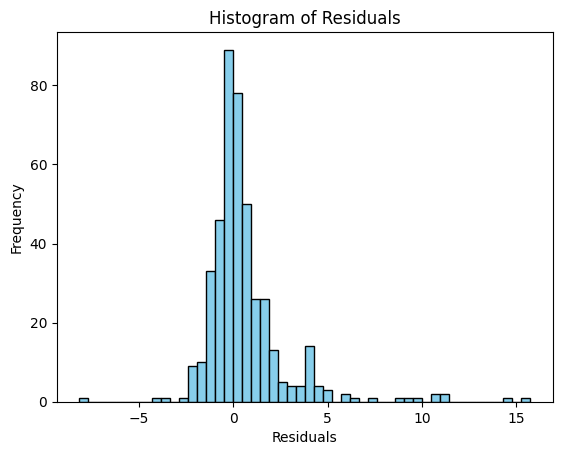

In [31]:
#Create plot of histograms
plt.hist(avg_residual, bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
 
# Display the plot
plt.show()